In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from olympus.objects import (
        ParameterContinuous,
        ParameterDiscrete,
        ParameterCategorical,
)
from olympus.planners import Planner
from olympus.campaigns import Campaign, ParameterSpace
from olympus.surfaces import Surface

from atlas.optimizers.gp.planner_general import BoTorchPlanner

In [4]:
def surface(x, s):
    if s == '0':
        return  np.sin(x[0])+ 12*np.cos(x[1]) - 0.1*x[2]
    elif s == '1':
        return 3*np.sin(x[0])+ 0.01*np.cos(x[1]) + 1.*x[2]**2
    elif s == '2':
        return 5*np.cos(x[0])+ 0.01*np.cos(x[1]) + 2.*x[2]**3
    
    
    

In [5]:
# evaluate the surface for the best points 
p1_domain = np.linspace(0, 1, 100)
p2_domain = np.linspace(0, 1, 100)
p3_domain = np.linspace(0, 1, 100)

params = []
measurements = []

for p1 in p1_domain:
    for p2 in p2_domain:
        for p3 in p3_domain:
            vals = []
            x = [p1, p2, p3]
            for s in ['0', '1', '2']:
                vals.append(surface(x, s))
            measurements.append(np.mean(vals))
            params.append(x)

            

In [6]:
best_ix = np.argmin(measurements)
best_val = measurements[best_ix]
best_params = params[best_ix]

In [7]:
best_ix, best_val, best_params

(9904, 3.830719239025027, [0.0, 1.0, 0.04040404040404041])

In [8]:
# make parameter space
param_space = ParameterSpace()

# add ligand
param_space.add(
    ParameterCategorical(
        name='param_0',
        options=[str(i) for i in range(3)],
        descriptors=[None for i in range(3)],        # add descriptors later
    )
)
# add temperature
param_space.add(
    ParameterContinuous(
        name='param_1',
        low=0.,
        high=1.
    )
)
# add residence time
param_space.add(
    ParameterContinuous(
        name='param_2',
        low=0.,
        high=1.
    )
)
# add catalyst loading
# summit expects this to be in nM
param_space.add(
    ParameterContinuous(
        name='param_3',
        low=0.,
        high=1.,
    )
)



In [9]:
BUDGET = 30
NUM_RUNS = 10

In [10]:
all_campaigns = []
all_true_measurements = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)

    planner = BoTorchPlanner(
        goal='minimize',
        general_parmeters=[0],
    )
    planner.set_param_space(param_space)

    true_measurements = []

    for iter in range(BUDGET):

        samples = planner.recommend(campaign.observations)
        #sample_arr = samples.to_array()
        measurement = surface(
            [float(samples.param_1), float(samples.param_2), float(samples.param_3)],
            samples.param_0,
        )

        all_measurements = []
        for s in param_space[0].options:
            all_measurements.append(
                surface(
                    [float(samples.param_1), float(samples.param_2), float(samples.param_3)],
                    s,
                )
            )
        true_measurements.append(np.mean(all_measurements))


        print(f'ITER : {iter}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
        campaign.add_observation(samples, measurement)
    
    all_true_measurements.append(true_measurements)
        
    all_campaigns.append(campaign)

ITER : 0	SAMPLES : ParamVector(param_0 = 0, param_1 = 0.8761102631061269, param_2 = 0.04025698524934329, param_3 = 0.4866543689286589)	 MEASUREMENT : 12.709866831263735
ITER : 1	SAMPLES : ParamVector(param_0 = 1, param_1 = 0.5364650119213655, param_2 = 0.9027858966961692, param_3 = 0.6767638790396663)	 MEASUREMENT : 1.9975059878322252
ITER : 2	SAMPLES : ParamVector(param_0 = 0, param_1 = 0.5492267316469371, param_2 = 0.46450309263808864, param_3 = 0.29051423130787357)	 MEASUREMENT : 11.221507777431666
ITER : 3	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.8726418827825784, param_2 = 0.3330914657980142, param_3 = 0.5861676120246879)	 MEASUREMENT : 3.6262810743118954
ITER : 4	SAMPLES : ParamVector(param_0 = 1, param_1 = 0.3713228098511323, param_2 = 0.34966626857350636, param_3 = 0.682919609768464)	 MEASUREMENT : 1.564319285431057
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.516 sec 


/home/riley/Software/anaconda3/envs/torch2/lib/python3.7/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


 >>> [1000 epochs] VGP trained in 1.953 sec 	 Loss : 0.0 
ITER : 5	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.06193266436457634, param_2 = 0.05321696400642395, param_3 = 0.0170756708830595)	 MEASUREMENT : 5.000409728285202
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 3.079 sec 
 >>> [1000 epochs] VGP trained in 1.92 sec 	 Loss : 0.0 
ITER : 6	SAMPLES : ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)	 MEASUREMENT : 6.3836276704176775
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.836 sec 
 >>> [1000 epochs] VGP trained in 1.917 sec 	 Loss : 0.0 
ITER : 7	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.5238227248191833, param_3 = 0.8980500102043152)	 MEASUREMENT : 6.457202702123132
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.264 sec 
 >>> [1000 epochs] VGP trained in 1.933 sec 	 Loss : 0.0 
ITER : 8	SAMPLES : ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.9577658772468567, param_3 = 0.0)	 MEASUREMENT : 2.530166441701349

 >>> [? epochs] GP trained in 1.382 sec 
 >>> [1000 epochs] VGP trained in 1.899 sec 	 Loss : 0.0 
ITER : 7	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.0762084499001503, param_2 = 0.5383257269859314, param_3 = 0.6526274681091309)	 MEASUREMENT : 5.550010980829231
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 2.514 sec 
 >>> [1000 epochs] VGP trained in 1.892 sec 	 Loss : 0.001 
ITER : 8	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)	 MEASUREMENT : 5.01
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.813 sec 
 >>> [1000 epochs] VGP trained in 1.924 sec 	 Loss : 0.0 
ITER : 9	SAMPLES : ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)	 MEASUREMENT : 7.325098655225574
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.549 sec 
 >>> [1000 epochs] VGP trained in 1.984 sec 	 Loss : 0.0 
ITER : 10	SAMPLES : ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)	 MEASUREMENT : 2.5298159774823707
cat dims :  [0

 >>> [? epochs] GP trained in 1.171 sec 
 >>> [1000 epochs] VGP trained in 1.923 sec 	 Loss : 0.0 
ITER : 9	SAMPLES : ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.010690215043723583, param_3 = 1.0)	 MEASUREMENT : 3.5344123830256424
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 1.151 sec 
 >>> [1000 epochs] VGP trained in 1.913 sec 	 Loss : 0.0 
ITER : 10	SAMPLES : ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.030792906880378723, param_3 = 1.0)	 MEASUREMENT : 4.711506788699737
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 1.109 sec 
 >>> [1000 epochs] VGP trained in 1.952 sec 	 Loss : 0.0 
ITER : 11	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.0045457445085048676, param_2 = 0.335857093334198, param_3 = 0.009416400454938412)	 MEASUREMENT : 5.00939129225333
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 4.705 sec 
 >>> [1000 epochs] VGP trained in 1.919 sec 	 Loss : 0.0 
ITER : 12	SAMPLES : ParamVector(param_0 = 1, param_1 = 0.6597304344177246, param_2 = 0.

 >>> [? epochs] GP trained in 1.661 sec 
 >>> [1000 epochs] VGP trained in 1.924 sec 	 Loss : 0.0 
ITER : 10	SAMPLES : ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)	 MEASUREMENT : 0.005403023058681398
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 2.314 sec 
 >>> [1000 epochs] VGP trained in 1.953 sec 	 Loss : 0.0 
ITER : 11	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9778756499290466)	 MEASUREMENT : 6.875572184671774
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.461 sec 
 >>> [1000 epochs] VGP trained in 1.936 sec 	 Loss : 0.0 
ITER : 12	SAMPLES : ParamVector(param_0 = 1, param_1 = 0.9950818419456482, param_2 = 0.37959912419319153, param_3 = 0.94861900806427)	 MEASUREMENT : 3.4255767346095003
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.412 sec 
 >>> [1000 epochs] VGP trained in 1.939 sec 	 Loss : 0.0 
ITER : 13	SAMPLES : ParamVector(param_0 = 0, param_1 = 0.99322909116745, param_2 = 0.3456149697303772, par

 >>> [1000 epochs] VGP trained in 1.981 sec 	 Loss : 0.0 
ITER : 11	SAMPLES : ParamVector(param_0 = 0, param_1 = 0.995241105556488, param_2 = 0.2566455006599426, param_3 = 0.0)	 MEASUREMENT : 12.44585321444741
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 1.641 sec 
 >>> [1000 epochs] VGP trained in 1.957 sec 	 Loss : 0.0 
ITER : 12	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.3221789598464966, param_3 = 0.0)	 MEASUREMENT : 5.009485477372998
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.413 sec 
 >>> [1000 epochs] VGP trained in 1.956 sec 	 Loss : 0.0 
ITER : 13	SAMPLES : ParamVector(param_0 = 0, param_1 = 0.011777645908296108, param_2 = 0.0, param_3 = 0.06888991594314575)	 MEASUREMENT : 12.004888382030549
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 1.306 sec 
 >>> [1000 epochs] VGP trained in 1.957 sec 	 Loss : 0.0 
ITER : 14	SAMPLES : ParamVector(param_0 = 1, param_1 = 0.9634007811546326, param_2 = 0.6621955633163452, param_3 = 0.019354213029146

 >>> [? epochs] GP trained in 1.097 sec 
 >>> [1000 epochs] VGP trained in 1.982 sec 	 Loss : 0.0 
ITER : 12	SAMPLES : ParamVector(param_0 = 0, param_1 = 0.6550062298774719, param_2 = 0.8885637521743774, param_3 = 0.002929924987256527)	 MEASUREMENT : 8.175200526848094
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 1.116 sec 
 >>> [1000 epochs] VGP trained in 1.977 sec 	 Loss : 0.001 
ITER : 13	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.9380289316177368, param_2 = 0.9864294528961182, param_3 = 0.9870395064353943)	 MEASUREMENT : 4.885650397896418
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 4.711 sec 
 >>> [1000 epochs] VGP trained in 2.01 sec 	 Loss : 0.0 
ITER : 14	SAMPLES : ParamVector(param_0 = 1, param_1 = 0.9860001802444458, param_2 = 0.9576148390769958, param_3 = 0.49385926127433777)	 MEASUREMENT : 2.751125601448717
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 1.764 sec 
 >>> [1000 epochs] VGP trained in 1.987 sec 	 Loss : 0.0 
ITER : 15	SAMPLES : ParamVecto

 >>> [? epochs] GP trained in 0.325 sec 
 >>> [1000 epochs] VGP trained in 1.96 sec 	 Loss : 0.0 
ITER : 13	SAMPLES : ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)	 MEASUREMENT : 7.325098655225574
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.346 sec 
 >>> [1000 epochs] VGP trained in 1.979 sec 	 Loss : 0.001 
ITER : 14	SAMPLES : ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)	 MEASUREMENT : 2.5298159774823707
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.466 sec 
 >>> [1000 epochs] VGP trained in 1.977 sec 	 Loss : 0.0 
ITER : 15	SAMPLES : ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)	 MEASUREMENT : 2.7069145523993803
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.655 sec 
 >>> [1000 epochs] VGP trained in 1.991 sec 	 Loss : 0.0 
ITER : 16	SAMPLES : ParamVector(param_0 = 1, param_1 = 0.16053013503551483, param_2 = 0.4395378530025482, param_3 = 0.0071733081713318825)	 MEASUREMENT : 0.4886255844

 >>> [? epochs] GP trained in 1.512 sec 
 >>> [1000 epochs] VGP trained in 1.985 sec 	 Loss : 0.0 
ITER : 15	SAMPLES : ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)	 MEASUREMENT : 7.225098655225574
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 2.325 sec 
 >>> [1000 epochs] VGP trained in 1.997 sec 	 Loss : 0.0 
ITER : 16	SAMPLES : ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)	 MEASUREMENT : 2.534412954423689
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 1.718 sec 
 >>> [1000 epochs] VGP trained in 2.016 sec 	 Loss : 0.0 
ITER : 17	SAMPLES : ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)	 MEASUREMENT : 2.7115115293406986
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 1.308 sec 
 >>> [1000 epochs] VGP trained in 2.031 sec 	 Loss : 0.0 
ITER : 18	SAMPLES : ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)	 MEASUREMENT : 3.5298159774823707
cat dims :  [0, 1, 2]
 >>> [? epochs] GP tra

 >>> [? epochs] GP trained in 3.242 sec 
 >>> [1000 epochs] VGP trained in 2.098 sec 	 Loss : 0.0 
ITER : 17	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.988759458065033, param_2 = 0.9044150710105896, param_3 = 0.9789133667945862)	 MEASUREMENT : 4.630943596956025
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 1.196 sec 
 >>> [1000 epochs] VGP trained in 2.104 sec 	 Loss : 0.0 
ITER : 18	SAMPLES : ParamVector(param_0 = 1, param_1 = 0.6070354580879211, param_2 = 0.04589078575372696, param_3 = 0.9990285634994507)	 MEASUREMENT : 2.719352739016805
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.811 sec 
 >>> [1000 epochs] VGP trained in 2.127 sec 	 Loss : 0.0 
ITER : 19	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.5567334294319153, param_2 = 0.0887419730424881, param_3 = 0.9952573180198669)	 MEASUREMENT : 6.226568027209681
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.782 sec 
 >>> [1000 epochs] VGP trained in 2.093 sec 	 Loss : 0.0 
ITER : 20	SAMPLES : ParamVector(pa

 >>> [? epochs] GP trained in 0.538 sec 
 >>> [1000 epochs] VGP trained in 1.981 sec 	 Loss : 0.0 
ITER : 18	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.9528015851974487, param_2 = 0.6037140488624573, param_3 = 0.028818784281611443)	 MEASUREMENT : 2.905289981606471
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.524 sec 
 >>> [1000 epochs] VGP trained in 1.992 sec 	 Loss : 0.001 
ITER : 19	SAMPLES : ParamVector(param_0 = 0, param_1 = 0.010710182599723339, param_2 = 0.20635320246219635, param_3 = 0.9608362913131714)	 MEASUREMENT : 11.66004179608709
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 1.216 sec 
 >>> [1000 epochs] VGP trained in 1.976 sec 	 Loss : 0.0 
ITER : 20	SAMPLES : ParamVector(param_0 = 1, param_1 = 0.09666144102811813, param_2 = 0.04378581419587135, param_3 = 0.9897682666778564)	 MEASUREMENT : 1.2791645963606615
cat dims :  [0, 1, 2]
 >>> [? epochs] GP trained in 0.941 sec 
 >>> [1000 epochs] VGP trained in 2.01 sec 	 Loss : 0.0 
ITER : 21	SAMPLES : Param

In [11]:
#campaign.observations.get_params()

In [ ]:
#campaign.observations.get_values()

In [14]:
len(all_true_measurements)

10

In [ ]:
best_ix = np.argmin(true_measurements)
best_params = campaign.observations.get_params()[best_ix]
best_ix, best_params

In [16]:
# random sampling runs
all_campaigns_random = []
all_true_measurements_random = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)

    planner = Planner(
        kind='RandomSearch',
        goal='minimize',
    )
    planner.set_param_space(param_space)

    true_measurements_random = []

    for iter in range(BUDGET):

        samples = planner.recommend(campaign.observations)
        #sample_arr = samples.to_array()
        measurement = surface(
            [float(samples.param_1), float(samples.param_2), float(samples.param_3)],
            samples.param_0,
        )

        all_measurements = []
        for s in param_space[0].options:
            all_measurements.append(
                surface(
                    [float(samples.param_1), float(samples.param_2), float(samples.param_3)],
                    s,
                )
            )
        true_measurements_random.append(np.mean(all_measurements))


        print(f'ITER : {iter}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
        campaign.add_observation(samples, measurement)
    
    all_true_measurements_random.append(true_measurements_random)    
    all_campaigns_random.append(campaign)

ITER : 0	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.8208624969884183, param_2 = 0.12874276284676167, param_3 = 0.9125181671829414)	 MEASUREMENT : 4.937557373761543
ITER : 1	SAMPLES : ParamVector(param_0 = 0, param_1 = 0.663185822859872, param_2 = 0.006881550228602151, param_3 = 0.2963014776474101)	 MEASUREMENT : 12.5857162305795
ITER : 2	SAMPLES : ParamVector(param_0 = 0, param_1 = 0.7514795717269654, param_2 = 0.24564181570330612, param_3 = 0.04673875337726108)	 MEASUREMENT : 12.317824108900176
ITER : 3	SAMPLES : ParamVector(param_0 = 0, param_1 = 0.8614598599191263, param_2 = 0.8508621989932735, param_3 = 0.6900442083611427)	 MEASUREMENT : 8.60181157081442
ITER : 4	SAMPLES : ParamVector(param_0 = 0, param_1 = 0.6661208154160484, param_2 = 0.5619918282044902, param_3 = 0.7331216455290261)	 MEASUREMENT : 10.698973361328036
ITER : 5	SAMPLES : ParamVector(param_0 = 2, param_1 = 0.7362323783662076, param_2 = 0.3871358005977359, param_3 = 0.6387141228305423)	 MEASUREMENT : 4.2354129812

In [24]:
regret_bo = np.array([np.minimum.accumulate(t-best_val) for t in all_true_measurements])
regret_rand = np.array([np.minimum.accumulate(t-best_val) for t in all_true_measurements_random])

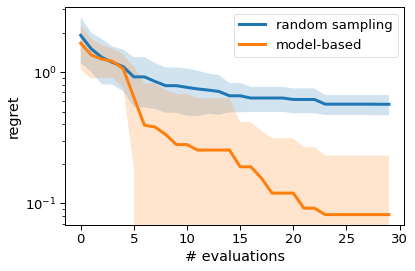

In [37]:
plt.plot(np.mean(regret_rand,axis=0), lw=3,label='random sampling')
plt.fill_between(
  np.arange(30),
  np.mean(regret_rand,axis=0)-np.std(regret_rand,axis=0),
  np.mean(regret_rand,axis=0)+np.std(regret_rand,axis=0),
  alpha=0.2
)
plt.plot(np.mean(regret_bo,axis=0), lw=3, label='model-based')
plt.fill_between(
  np.arange(30),
  np.mean(regret_bo,axis=0)-np.std(regret_bo,axis=0),
  np.mean(regret_bo,axis=0)+np.std(regret_bo,axis=0),
  alpha=0.2
)
plt.yscale('log')
plt.ylabel('regret')
plt.xlabel('# evaluations')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('synthetic_general_conditions.png', dpi=300)